In [2]:
# MobileNet_V3 전이학습

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import decode_predictions
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import numpy as np

In [3]:
import tensorflow as tf

In [4]:
##### 전이학습 시작 #####

In [5]:
(train_images_raw, train_labels_raw), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

169001437/169001437 [==============================] - 14s 0us/step


In [6]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_images = preprocess_input(input_images)
  return output_images

In [7]:
train_images = train_images_raw[:45000]
train_labels = train_labels_raw[:45000]

In [8]:
valid_images = train_images_raw[40000:]
valid_labels = train_labels_raw[40000:]

In [9]:
train_X = preprocess_image_input(train_images)
valid_X = preprocess_image_input(valid_images)

In [10]:
feature_extractor = MobileNetV3Large(input_shape=(224,224,3),
                                                include_top=False,
                                                weights='imagenet')

12683000/12683000 [==============================] - 2s 0us/step


In [11]:
feature_extractor.trainable = False

In [12]:
feature_extractor.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [14]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
x = feature_extractor(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
# output classification count: 20
outputs = tf.keras.layers.Dense(20, activation="softmax", name="classification")(x)

In [15]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               492032    
                                                             

In [18]:
EPOCHS = 5

history = model.fit(train_X, train_labels, epochs=EPOCHS,
                    validation_data=(valid_X, valid_labels), batch_size=100, shuffle=True)

Epoch 1/5
450/450 [==============================] - 66s 123ms/step - loss: 1.9500 - accuracy: 0.4109 - val_loss: 1.4931 - val_accuracy: 0.5271
Epoch 2/5
450/450 [==============================] - 55s 123ms/step - loss: 1.3759 - accuracy: 0.5626 - val_loss: 1.2774 - val_accuracy: 0.5946
Epoch 3/5
450/450 [==============================] - 55s 122ms/step - loss: 1.2278 - accuracy: 0.6081 - val_loss: 1.2030 - val_accuracy: 0.6187
Epoch 4/5
450/450 [==============================] - 55s 122ms/step - loss: 1.1432 - accuracy: 0.6334 - val_loss: 1.1219 - val_accuracy: 0.6427
Epoch 5/5
450/450 [==============================] - 54s 121ms/step - loss: 1.0819 - accuracy: 0.6543 - val_loss: 1.0888 - val_accuracy: 0.6526


In [19]:
test_images = preprocess_image_input(test_images)
results = model.evaluate(test_images, test_labels)
test = model.predict(test_images)
print(results[1])

313/313 [==============================] - 11s 31ms/step
0.6306999921798706


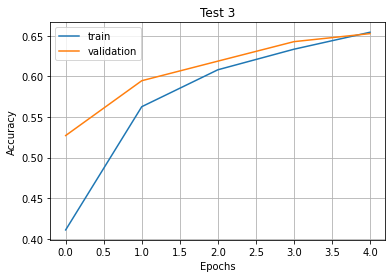

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Test 3')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.grid()
plt.show()